<a href="https://colab.research.google.com/github/Schimidel/UGRH-s-Precipita-oeTemperatura/blob/main/Atividade_Wavelets_Temperatura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importa as bibliotecas
import xarray as xr #Biblioteca para netcdf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Abre os arquivos no drive
temp_NOAA = xr.open_dataset("drive/MyDrive/Precipitacao_e_Indices/temp_NOAA.nc").air
temp_NCEP = xr.open_dataset("drive/MyDrive/Precipitacao_e_Indices/temp_NCEP.nc").air

In [ ]:
#Cria a série temporal com os dados de grade para a área do shape
mean_NOAA = temp_NOAA.mean(dim=['latitude', 'longitude'])
mean_NCEP = temp_NCEP.mean(dim=['lat', 'lon'])

In [ ]:
#Calcula as anomalias mensais
anom_NCEP = mean_NCEP - mean_NCEP.sel(time=slice('1981', '2011')).mean(dim='time')
anom_NOAA = mean_NOAA- mean_NOAA.sel(time=slice('1981', '2011')).mean(dim='time')

In [ ]:
#Transforma os dados para dataframe
df_NCEP = anom_NCEP.to_dataframe()
df_NCEP.index = df_NCEP.index.strftime('%Y-%m')
df_NCEP = df_NCEP.rename(columns={'prate' : "precip"})
df_NOAA = anom_NOAA.to_dataframe()
df_NOAA.index = df_NOAA.index.strftime('%Y-%m')

In [ ]:
df_NCEP = df_NCEP.reset_index()
df_NOAA = df_NOAA.reset_index()

In [ ]:
df_NCEP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    604 non-null    object 
 1   air     604 non-null    float32
dtypes: float32(1), object(1)
memory usage: 7.2+ KB


In [ ]:
df_NOAA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    603 non-null    object 
 1   air     603 non-null    float32
dtypes: float32(1), object(1)
memory usage: 7.2+ KB


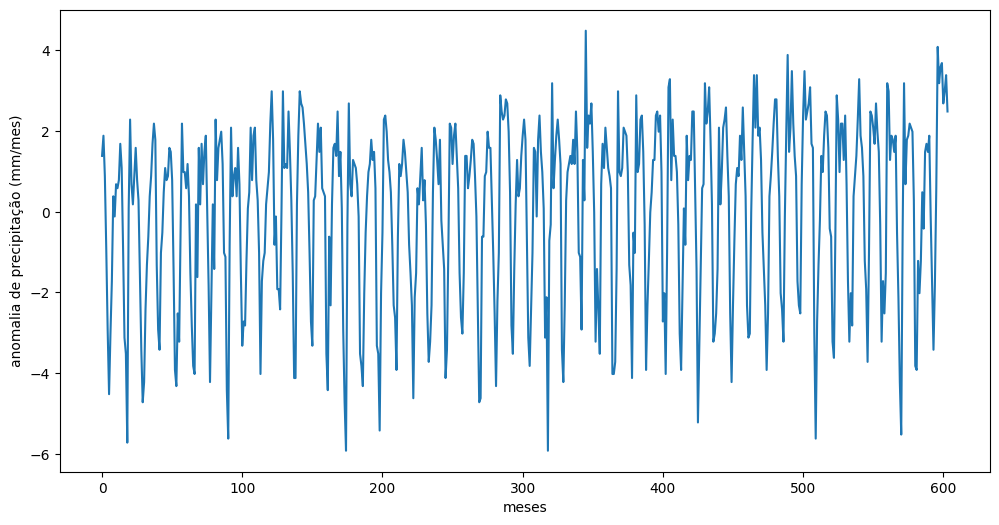

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df_NCEP.air.plot()
plt.xlabel('meses')
plt.ylabel('anomalia de precipitação (mm/mes)')
plt.show()

In [ ]:
%%capture
# instala o wavelets
!pip install pycwt

In [ ]:
# primeiro importa o que vamos usar
import pycwt as wavelet
from pycwt.helpers import find
import numpy as np

In [ ]:
# algumas definições

# para 1° teste
dat = np.array(df_NCEP.air) # simplesmente converte o meu Dataframe para um array usando o numpy
title = 'Precipitação teste'
label = 'Anomalia de Temperatura'
units = 'Anomalia °C'
t0 = 0
dt = 1/12  # em anos

periodo_interesse = [0,1] # estou interessado em analizar a variância dentro de um período de interesse, em anos

N = dat.size
t = np.arange(0, N) * dt + t0

In [ ]:
# vamos olhar nosso "t"
t

array([ 0.        ,  0.08333333,  0.16666667,  0.25      ,  0.33333333,
        0.41666667,  0.5       ,  0.58333333,  0.66666667,  0.75      ,
        0.83333333,  0.91666667,  1.        ,  1.08333333,  1.16666667,
        1.25      ,  1.33333333,  1.41666667,  1.5       ,  1.58333333,
        1.66666667,  1.75      ,  1.83333333,  1.91666667,  2.        ,
        2.08333333,  2.16666667,  2.25      ,  2.33333333,  2.41666667,
        2.5       ,  2.58333333,  2.66666667,  2.75      ,  2.83333333,
        2.91666667,  3.        ,  3.08333333,  3.16666667,  3.25      ,
        3.33333333,  3.41666667,  3.5       ,  3.58333333,  3.66666667,
        3.75      ,  3.83333333,  3.91666667,  4.        ,  4.08333333,
        4.16666667,  4.25      ,  4.33333333,  4.41666667,  4.5       ,
        4.58333333,  4.66666667,  4.75      ,  4.83333333,  4.91666667,
        5.        ,  5.08333333,  5.16666667,  5.25      ,  5.33333333,
        5.41666667,  5.5       ,  5.58333333,  5.66666667,  5.75

In [ ]:
p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

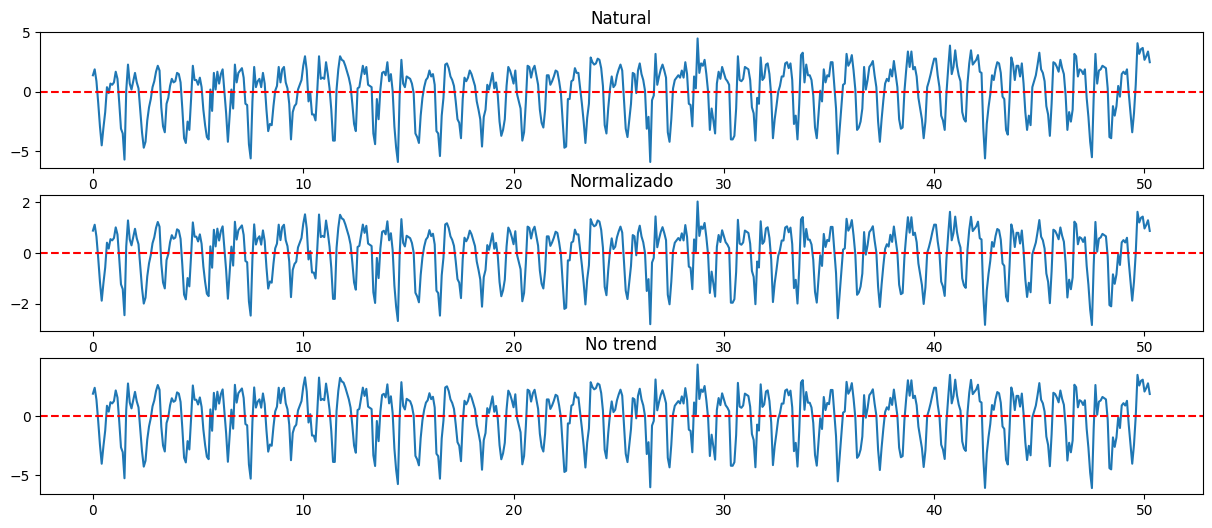

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(15,6))
ax[0].plot(t,dat)
ax[0].set_title('Natural')
ax[0].axhline(y=0,linestyle='--',color='r')

ax[1].plot(t,dat_norm)
ax[1].set_title('Normalizado')
ax[1].axhline(y=0,linestyle='--',color='r')

ax[2].plot(t,dat_notrend)
ax[2].set_title('No trend')
ax[2].axhline(y=0,linestyle='--',color='r')
plt.show()

A próxima etapa é definir alguns parâmetros de nossa análise de wavelet. Selecionamos a wavelet mãe, neste caso a wavelet de Morlet com ω0 = 6.

In [ ]:
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Escala inicial, neste caso 0.25 * 4 meses = 1 ano # note que isso pode variar dependendo de como seu dado está.
dj = 1 / 12  # 12 sub-oitavas por oitavas
J = 8 / dj  # 8 potências de dois com sub-oitavas dj
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelação para ruído vermelho !!!! muito importante !!!!!

In [ ]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,mother)
#wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat, dt, dj, s0, J,mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

Calculamos a wavelet normalizada e os espectros de potência de Fourier, bem como os períodos equivalentes de Fourier para cada escala de wavelet.

In [ ]:
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

In [ ]:
# Opcionalmente, também poderíamos retificar o espectro de potência
# de acordo com as sugestões propostas por Liu et al. (2007) [2]
#power /= scales[:, None]

Poderíamos parar neste ponto e traçar nossos resultados. No entanto, também estamos interessados no teste de significância de espectros de potência. A potência é significativa onde a relação potência / sig95> 1.

In [ ]:
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.75, #<---- veja
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

Em seguida, calculamos o espectro wavelet global e determinamos seu nível de significância.

In [ ]:
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.75, dof=dof, #<---- veja
                                        wavelet=mother)

Também calculamos a média da escala entre 0 e X anos (de interesse) e seu nível de significância.

In [ ]:

sel = find((period >= periodo_interesse[0]) & (period <= periodo_interesse[1]))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.75, #<---- veja
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

Finalmente, plotamos nossos resultados em quatro subparcelas diferentes contendo a (i) anomalia da série original e a transformada wavelet inversa; (ii) o espectro de potência da wavelet (iii) o espectro global da wavelet e de Fourier; e (iv) o espectro de wavelet de média de alcance. Em todos os subgráficos, os níveis de significância são incluídos como linhas pontilhadas ou como linhas de contorno preenchidas.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


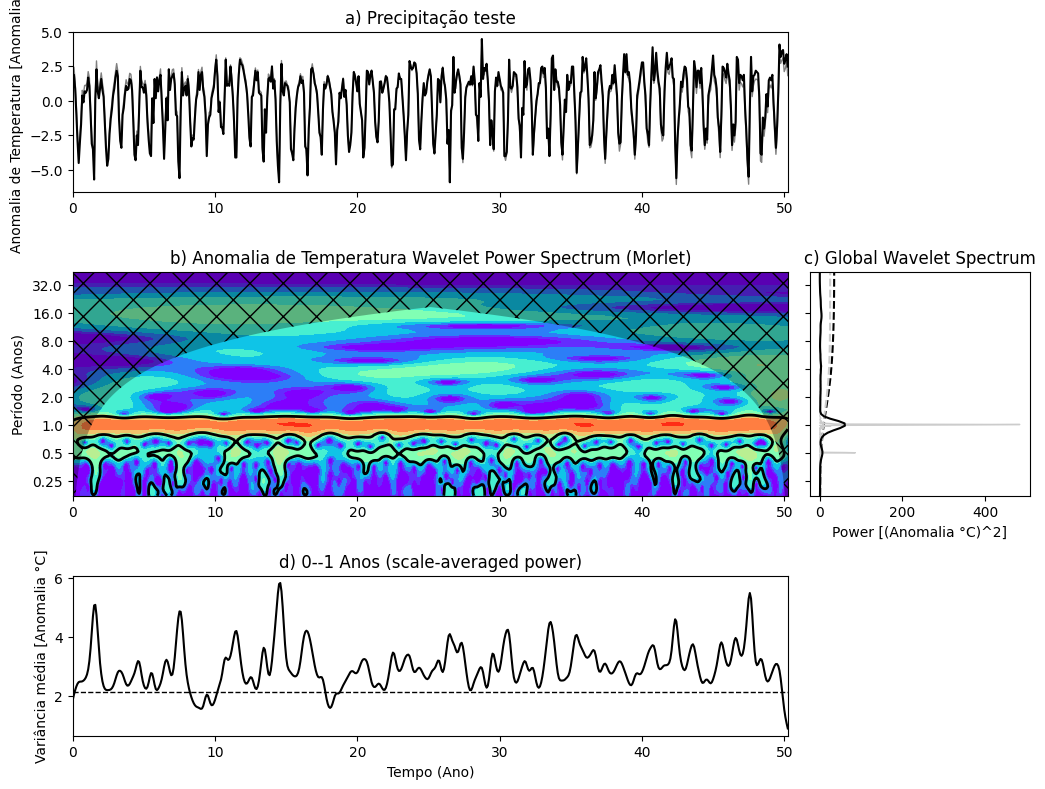

In [ ]:
### Receita de Bolo ###
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(11, 8))

# Primeiro sub-gráfico, a anomalia da série temporal original e wavelet inversa.
ax = plt.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Segundo sub-gráfico, o espectro de potência da wavelet normalizada e significância
bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
bx.contourf(t, np.log2(period), np.log2(power), levels=np.log2(levels), extend='both', cmap=plt.cm.rainbow)
extent = [t.min(), t.max(), np.log2(period.min()), np.log2(period.max())]
bx.contour(t, np.log2(period), sig95, levels=[-99, 1], colors='k', linewidths=2, extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt, t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]), np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Período (Anos)')

Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)

# Terceiro sub-gráfico, wavelet global e espectros de potência de Fourier e teóricos
cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, np.log2(period), 'k--')
cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc', linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)

cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
#cx.set_xlim([0, glbl_power.max() + var]) # sinto que não há necessidade de limitar aqui
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)

# Quarto sub-gráfico, o espectro de ondas médias da escala.
dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} Anos (scale-averaged power)'.format(periodo_interesse[0], periodo_interesse[1]))
dx.set_xlabel('Tempo (Ano)')
dx.set_ylabel(r'Variância média [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

plt.show()


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realizando a decomposição sazonal da série temporal de precipitação
decomp = seasonal_decompose(df_NCEP['air'], model='additive', period=12,two_sided=True)  # Ajuste o período conforme necessário

# Obtendo a componente sazonal
sazonal = decomp.seasonal

# Removendo a componente sazonal da série temporal de SST
no_season = df_NCEP['air'] - sazonal

In [ ]:
no_season

0     -0.473946
1      0.084133
2     -0.410765
3     -0.790526
4     -0.466887
         ...   
599    2.044508
600    0.826055
601    1.184133
602    2.089235
603    2.609473
Length: 604, dtype: float64

In [ ]:
# algumas definições

# para 1° teste
dat = np.array(no_season) # simplesmente converte o meu Dataframe para um array usando o numpy
title = 'Temperatura teste'
label = 'Anomalia de Temperatura'
units = 'anomalia °C'
t0 = 0
dt = 1/12  # em anos

periodo_interesse = [0,1] # estou interessado em analizar a variância dentro de um período de interesse, em anos

N = dat.size
t = np.arange(0, N) * dt + t0

In [ ]:
# vamos olhar nosso "t"
t

array([ 0.        ,  0.08333333,  0.16666667,  0.25      ,  0.33333333,
        0.41666667,  0.5       ,  0.58333333,  0.66666667,  0.75      ,
        0.83333333,  0.91666667,  1.        ,  1.08333333,  1.16666667,
        1.25      ,  1.33333333,  1.41666667,  1.5       ,  1.58333333,
        1.66666667,  1.75      ,  1.83333333,  1.91666667,  2.        ,
        2.08333333,  2.16666667,  2.25      ,  2.33333333,  2.41666667,
        2.5       ,  2.58333333,  2.66666667,  2.75      ,  2.83333333,
        2.91666667,  3.        ,  3.08333333,  3.16666667,  3.25      ,
        3.33333333,  3.41666667,  3.5       ,  3.58333333,  3.66666667,
        3.75      ,  3.83333333,  3.91666667,  4.        ,  4.08333333,
        4.16666667,  4.25      ,  4.33333333,  4.41666667,  4.5       ,
        4.58333333,  4.66666667,  4.75      ,  4.83333333,  4.91666667,
        5.        ,  5.08333333,  5.16666667,  5.25      ,  5.33333333,
        5.41666667,  5.5       ,  5.58333333,  5.66666667,  5.75

In [ ]:
p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

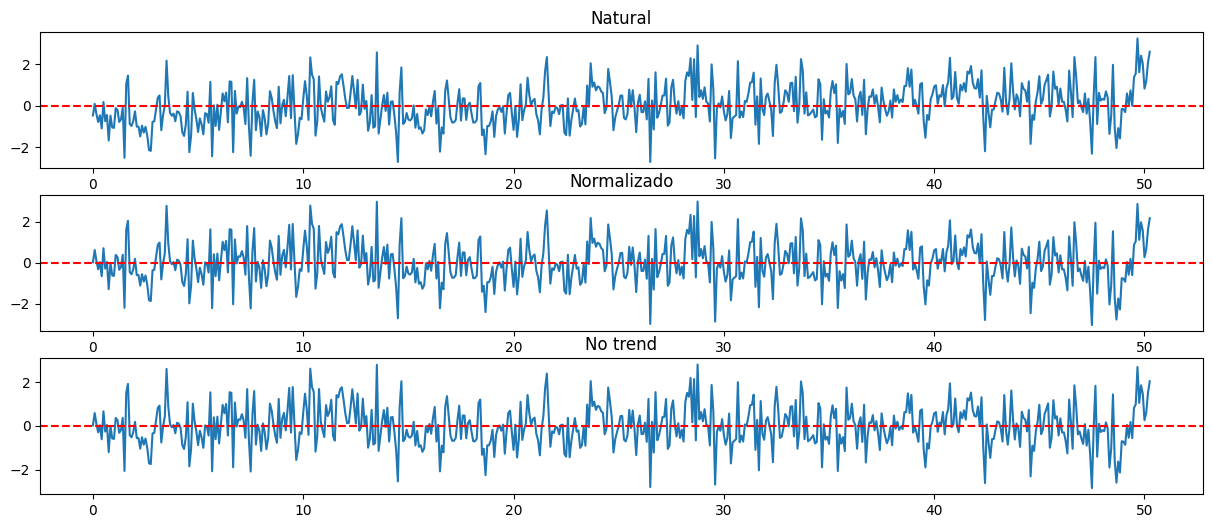

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(15,6))
ax[0].plot(t,dat)
ax[0].set_title('Natural')
ax[0].axhline(y=0,linestyle='--',color='r')

ax[1].plot(t,dat_norm)
ax[1].set_title('Normalizado')
ax[1].axhline(y=0,linestyle='--',color='r')

ax[2].plot(t,dat_notrend)
ax[2].set_title('No trend')
ax[2].axhline(y=0,linestyle='--',color='r')
plt.show()

A próxima etapa é definir alguns parâmetros de nossa análise de wavelet. Selecionamos a wavelet mãe, neste caso a wavelet de Morlet com ω0 = 6.

In [ ]:
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Escala inicial, neste caso 0.25 * 4 meses = 1 ano # note que isso pode variar dependendo de como seu dado está.
dj = 1 / 12  # 12 sub-oitavas por oitavas
J = 8 / dj  # 8 potências de dois com sub-oitavas dj
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelação para ruído vermelho !!!! muito importante !!!!!

**Se você não sabe o que é um ruido vermelho - PROCURE !**

As rotinas a seguir realizam a transformação wavelet e a transformada wavelet inversa usando os parâmetros definidos acima. Como normalizamos nossa série temporal de entrada, multiplicamos a transformação inversa pelo desvio padrão.

In [ ]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,mother)
#wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat, dt, dj, s0, J,mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

Calculamos a wavelet normalizada e os espectros de potência de Fourier, bem como os períodos equivalentes de Fourier para cada escala de wavelet.

In [ ]:
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

In [ ]:
# Opcionalmente, também poderíamos retificar o espectro de potência
# de acordo com as sugestões propostas por Liu et al. (2007) [2]
#power /= scales[:, None]

Poderíamos parar neste ponto e traçar nossos resultados. No entanto, também estamos interessados no teste de significância de espectros de potência. A potência é significativa onde a relação potência / sig95> 1.

In [ ]:
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.75, #<---- veja
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

Em seguida, calculamos o espectro wavelet global e determinamos seu nível de significância.

In [ ]:
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.75, dof=dof, #<---- veja
                                        wavelet=mother)

Também calculamos a média da escala entre 0 e X anos (de interesse) e seu nível de significância.

In [ ]:

sel = find((period >= periodo_interesse[0]) & (period <= periodo_interesse[1]))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.75, #<---- veja
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

Finalmente, plotamos nossos resultados em quatro subparcelas diferentes contendo a (i) anomalia da série original e a transformada wavelet inversa; (ii) o espectro de potência da wavelet (iii) o espectro global da wavelet e de Fourier; e (iv) o espectro de wavelet de média de alcance. Em todos os subgráficos, os níveis de significância são incluídos como linhas pontilhadas ou como linhas de contorno preenchidas.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


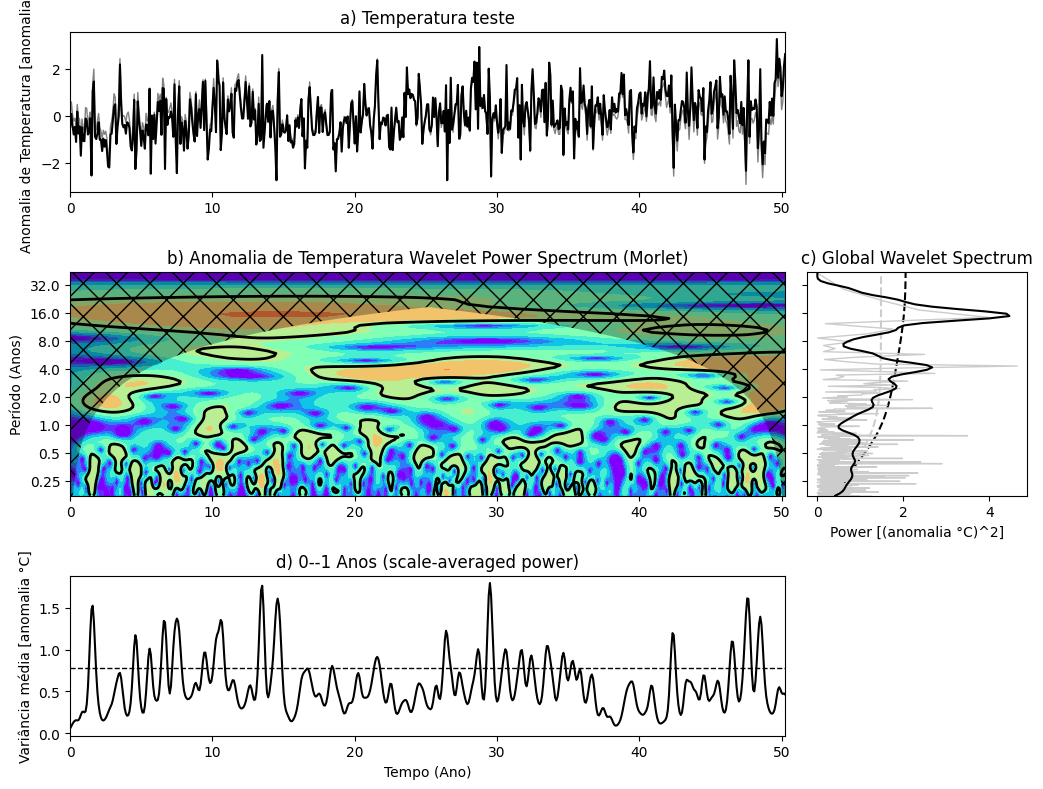

In [ ]:
### Receita de Bolo ###
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(11, 8))

# Primeiro sub-gráfico, a anomalia da série temporal original e wavelet inversa.
ax = plt.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Segundo sub-gráfico, o espectro de potência da wavelet normalizada e significância
bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
bx.contourf(t, np.log2(period), np.log2(power), levels=np.log2(levels), extend='both', cmap=plt.cm.rainbow)
extent = [t.min(), t.max(), np.log2(period.min()), np.log2(period.max())]
bx.contour(t, np.log2(period), sig95, levels=[-99, 1], colors='k', linewidths=2, extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt, t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]), np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Período (Anos)')

Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)

# Terceiro sub-gráfico, wavelet global e espectros de potência de Fourier e teóricos
cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, np.log2(period), 'k--')
cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc', linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)

cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
#cx.set_xlim([0, glbl_power.max() + var]) # sinto que não há necessidade de limitar aqui
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)

# Quarto sub-gráfico, o espectro de ondas médias da escala.
dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} Anos (scale-averaged power)'.format(periodo_interesse[0], periodo_interesse[1]))
dx.set_xlabel('Tempo (Ano)')
dx.set_ylabel(r'Variância média [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

plt.show()
